In [1]:
import os
import sys
from pathlib import Path

import torch
from matplotlib import pyplot as plt
from torch.nn import functional as F
from torch.optim import SGD, Adam
from torch.utils.data import DataLoader

sys.path.append(os.fspath(Path.cwd().parent.resolve()))

In [2]:
from anime4k_torch.data import NpyDataset, transform_image_train, transform_image_eval
from anime4k_torch.metric import yuv_error
from anime4k_torch.model import SR2Model
from anime4k_torch.training import eval_loop, train_loop
from anime4k_torch.visualization import show_images

In [3]:
data_dir = Path("../../data/synla").resolve()
dataloader_config = {"batch_size": 32, "num_workers": 8, "pin_memory": True}

train_set = NpyDataset(data_dir / "synla_4096.npy", transform_image_train)
train_loader = DataLoader(train_set, shuffle=True, drop_last=True, **dataloader_config)

validation_set = NpyDataset(data_dir / "synla_1024.npy", transform_image_eval)
validation_loader = DataLoader(validation_set, **dataloader_config)

In [4]:
checkpoint_dir = Path("../checkpoints").resolve()
checkpoint_dir.mkdir(exist_ok=True)

In [5]:
model = SR2Model(highway_depth=4, block_depth=7)
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"
model.to(device)

# Super-convergence with clipping
optimizer = SGD(model.parameters(), lr=320000.0, momentum=0.9, nesterov=True)
train_loss = train_loop(
    model, optimizer, yuv_error, train_loader, clip_grad_norm=0.00000001, epochs=32
)
print("Average loss:", train_loss)
validation_loss = eval_loop(model, yuv_error, validation_loader)
print("Average loss:", validation_loss)

# Fine tuning with Adam
for learning_rate in 0.032, 0.0032:
    optimizer = Adam(model.parameters(), learning_rate)
    train_loss = train_loop(model, optimizer, yuv_error, train_loader, epochs=64)
    print("Average loss:", train_loss)
    validation_loss = eval_loop(model, yuv_error, validation_loader)
    print("Average loss:", validation_loss)

torch.save(model.state_dict(), checkpoint_dir / "synla.pth")

Training: 100%|██████████| 4096/4096 [02:31<00:00, 27.00it/s, batch_loss=0.00243]


Average loss: 0.00437360668030351


Evaluation: 100%|██████████| 32/32 [00:00<00:00, 74.42it/s, batch_loss=0.0011] 


Average loss: 0.0012334691527939867


Training: 100%|██████████| 8192/8192 [05:02<00:00, 27.06it/s, batch_loss=0.00408]


Average loss: 0.01454498462382503


Evaluation: 100%|██████████| 32/32 [00:00<00:00, 80.61it/s, batch_loss=0.00135]


Average loss: 0.0014792051442782395


Training: 100%|██████████| 8192/8192 [05:01<00:00, 27.15it/s, batch_loss=0.00299]


Average loss: 0.0029600144149810603


Evaluation: 100%|██████████| 32/32 [00:00<00:00, 75.88it/s, batch_loss=0.00103]


Average loss: 0.0011599585523072165


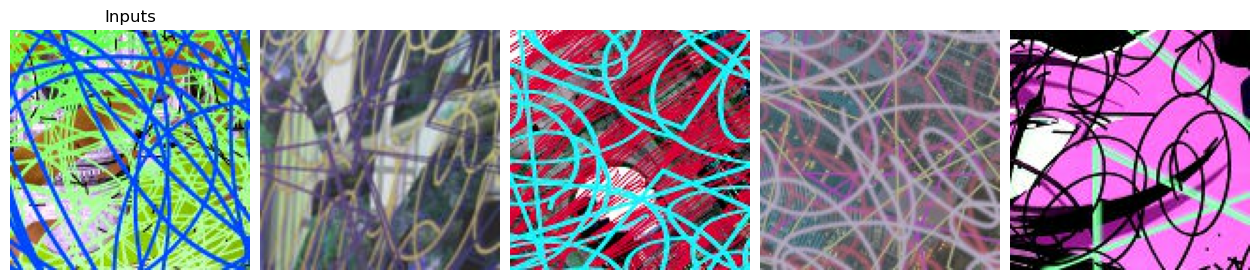

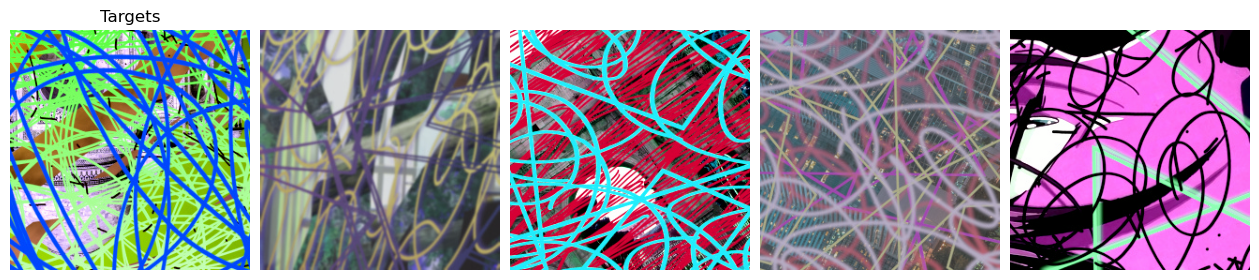

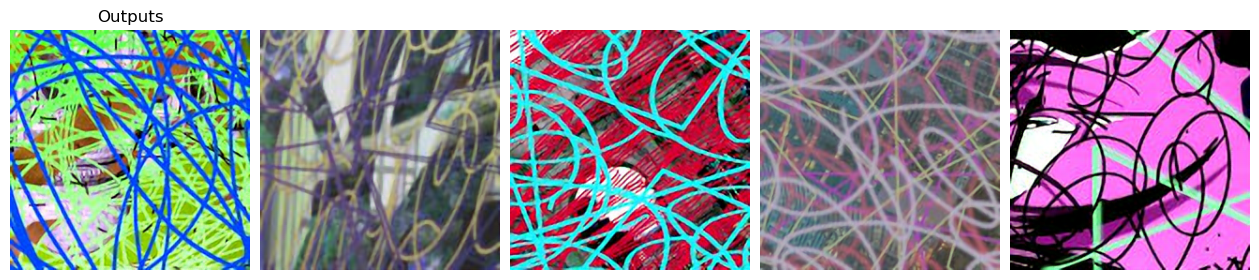

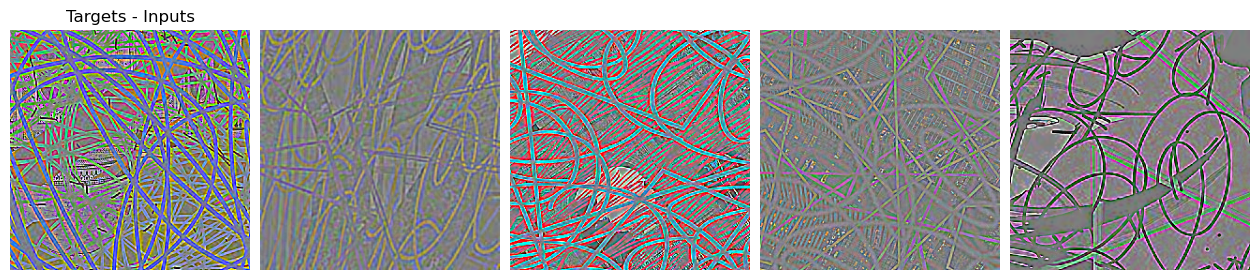

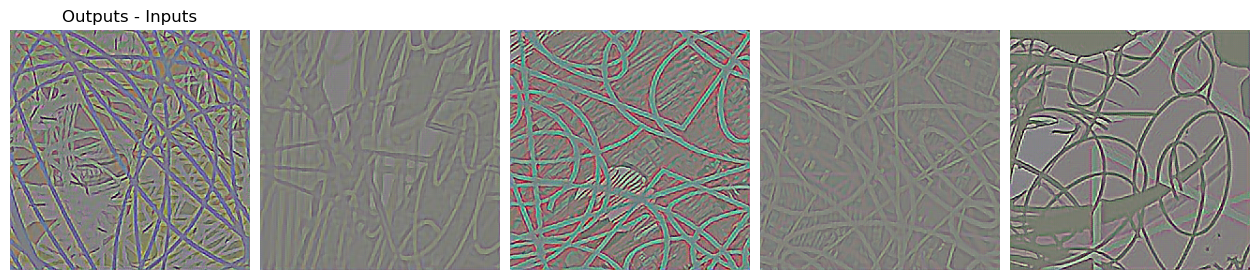

In [6]:
figsize = (20, 20)

inputs, targets = next(iter(train_loader))
inputs = inputs[:5].to(device)
targets = targets[:5].to(device)
model.eval()
with torch.no_grad():
    outputs = model(inputs)

figsize = (16, 16)

figure = plt.figure(figsize=figsize)
show_images(figure, inputs)
figure.axes[0].set_title("Inputs")

figure = plt.figure(figsize=figsize)
show_images(figure, targets)
figure.axes[0].set_title("Targets")

figure = plt.figure(figsize=figsize)
show_images(figure, outputs)
figure.axes[0].set_title("Outputs")

upsampled_inputs = F.interpolate(inputs, scale_factor=2, mode="bilinear")

figure = plt.figure(figsize=figsize)
show_images(figure, targets - upsampled_inputs, value_range=(-0.2, 0.2))
figure.axes[0].set_title("Targets - Inputs")

figure = plt.figure(figsize=figsize)
show_images(figure, outputs - upsampled_inputs, value_range=(-0.2, 0.2))
figure.axes[0].set_title("Outputs - Inputs")

None  # Suppress output.